In [ ]:
import json
import os
import typing
from collections import defaultdict, namedtuple
from functools import partial
from pathlib import Path
from typing import Type

import einops
import numpy as np
import pandas as pd
import torch as t
from devinterp.optim.sgld import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import evaluate_ce, plot_trace
from devinterp.vis_utils import EpsilonBetaAnalyzer
from jaxtyping import Float
from torch import Tensor, nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split

import wandb
from pizza_clock.config import Config, get_device
from pizza_clock.dataset import AdditionDataset, get_train_val_data
from pizza_clock.metrics import compute_gradient_similarity
from pizza_clock.training import ModularAdditionModelTrainer


In [ ]:
def evaluate_last_position(criterion, model, data):
    x, y = data
    out = model(x)
    logits = out[:, -1, :]  # Get the last position's logits: [batch, vocab]
    return criterion(logits, y), {"output": logits}


evaluate_last_position_ce = partial(evaluate_last_position, F.cross_entropy)


def estimate_llc_given_model(
    model: t.nn.Module,
    loader: t.utils.data.DataLoader,
    evaluate: typing.Callable,
    epsilon: float,
    beta: float,
    sampling_method: Type[t.optim.Optimizer] = SGLD,
    localization: float = 5.0,
    num_chains: int = 2,
    num_draws: int = 500,
    num_burnin_steps: int = 0,
    num_steps_bw_draws: int = 1,
    device: t.device = get_device(),
    online: bool = True,
    verbose: bool = False,
):
    # Copied from devinterp grokking notebook https://github.com/timaeus-research/devinterp/blob/main/examples/grokking.ipynb
    sweep_stats = estimate_learning_coeff_with_summary(
        model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=sampling_method,
        optimizer_kwargs=dict(lr=epsilon, localization=localization, nbeta=beta),
        num_chains=num_chains,  # How many independent chains to run
        num_draws=num_draws,  # How many samples to draw per chain
        num_burnin_steps=num_burnin_steps,  # How many samples to discard at the beginning of each chain
        num_steps_bw_draws=num_steps_bw_draws,  # How many steps to take between each sample
        device=device,
        online=online,
        verbose=verbose,
    )

    sweep_stats["llc/trace"] = np.array(sweep_stats["llc/trace"])
    return sweep_stats


def load_model_and_config(dir_path: str):
    config_json = json.load(open(f"{dir_path}/config.json", "r"))
    config = Config(**config_json)
    final_model = t.load(
        f"{dir_path}/final_model.pt", map_location=get_device(), weights_only=False
    )
    all_models = [
        t.load(
            f"{dir_path}/model_{i}.pt", map_location=get_device(), weights_only=False
        )
        for i in range(len(list(Path(dir_path).glob("model_*.pt"))))
    ]
    return final_model, config, all_models


def sweep(dir_path: str, min_epsilon=3e-7, max_epsilon=3e-4):
    final_model, config, all_models = load_model_and_config(dir_path)
    train_loader, _ = get_train_val_data(config, squeeze_targets=True)

    analyzer = EpsilonBetaAnalyzer()
    analyzer.configure_sweep(
        llc_estimator=estimate_llc_given_model,
        llc_estimator_kwargs=dict(
            model=final_model,
            evaluate=evaluate_last_position_ce,  # Use custom evaluate function
            device=get_device(),
            loader=train_loader,
        ),
        min_epsilon=min_epsilon,
        max_epsilon=max_epsilon,
        epsilon_samples=5,
        min_beta=None,
        max_beta=None,
        beta_samples=5,
        dataloader=train_loader,
    )
    analyzer.sweep()
    analyzer.plot(div_out_beta=True)
    return analyzer


def estimate_and_plot_llc_for_final_model(
    dir_path, lr=1e-5, nbeta=10.0, localization=10.0, num_chains=3, num_draws=1500
):
    final_model, config, all_models = load_model_and_config(dir_path)
    train_loader, _ = get_train_val_data(config, squeeze_targets=True)

    learning_coeff_stats = estimate_learning_coeff_with_summary(
        final_model,
        loader=train_loader,
        evaluate=evaluate_last_position_ce,
        sampling_method=SGLD,
        optimizer_kwargs=dict(lr=lr, nbeta=nbeta, localization=localization),
        num_chains=num_chains,
        num_draws=num_draws,
        device=get_device(),
        online=True,
    )
    trace = learning_coeff_stats["loss/trace"]
    avg_llc = sum(learning_coeff_stats["llc/means"]) / len(
        learning_coeff_stats["llc/means"]
    )
    print(dir_path)
    plot_trace(
        trace,
        "Loss",
        x_axis="Step",
        title=f"Loss Trace, avg LLC = {avg_llc:.2f}",
        plot_mean=False,
        plot_std=False,
        fig_size=(12, 9),
        true_lc=None,
    )
    return avg_llc

/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be 

saved_models/2026-01-27/attn0.0_seed0


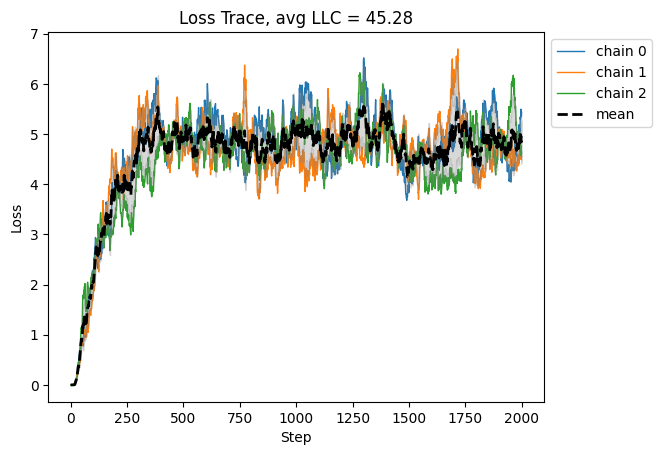

<Figure size 1200x900 with 0 Axes>

/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be 

saved_models/2026-01-27/attn0.0_seed1


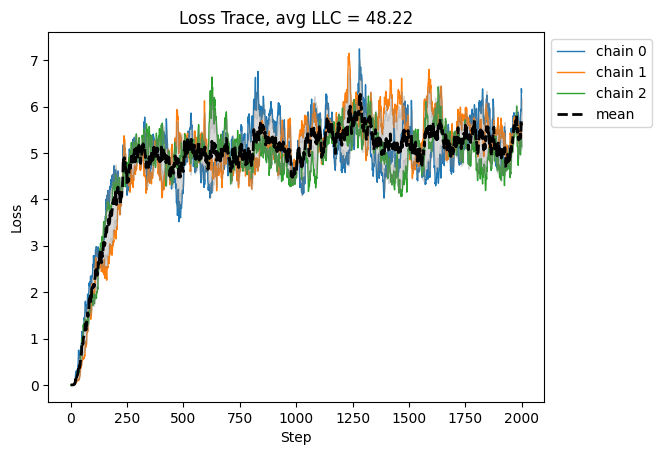

<Figure size 1200x900 with 0 Axes>

Chain 2: 100%|██████████| 2000/2000 [00:21<00:00, 91.62it/s]


saved_models/2026-01-27/attn0.0_seed2


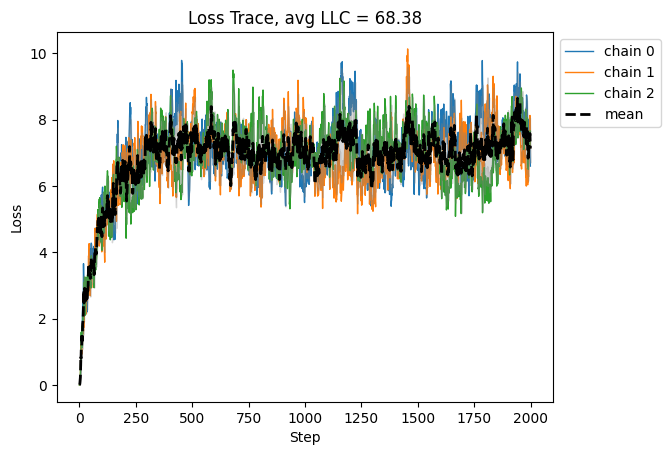

<Figure size 1200x900 with 0 Axes>

Chain 2: 100%|██████████| 2000/2000 [00:21<00:00, 92.12it/s]


saved_models/2026-01-27/attn0.0_seed3


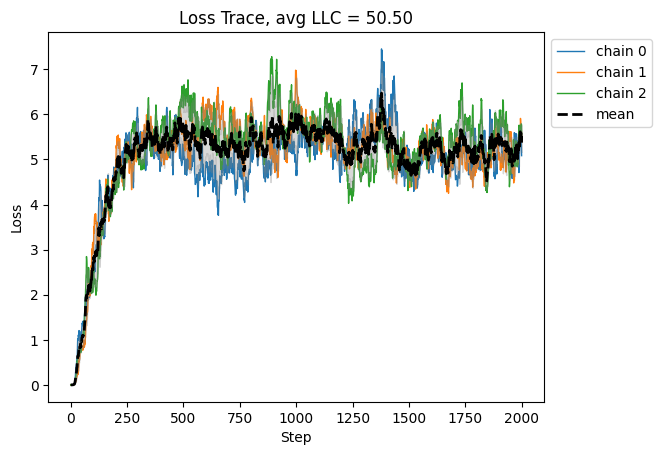

<Figure size 1200x900 with 0 Axes>

Chain 2: 100%|██████████| 2000/2000 [00:21<00:00, 92.08it/s]

saved_models/2026-01-27/attn0.0_seed4


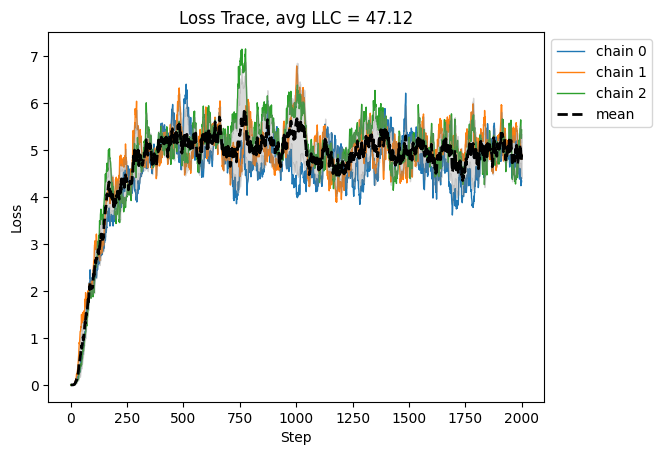

<Figure size 1200x900 with 0 Axes>

Chain 2: 100%|██████████| 2000/2000 [00:21<00:00, 91.72it/s]


saved_models/2026-01-27/attn1.0_seed0


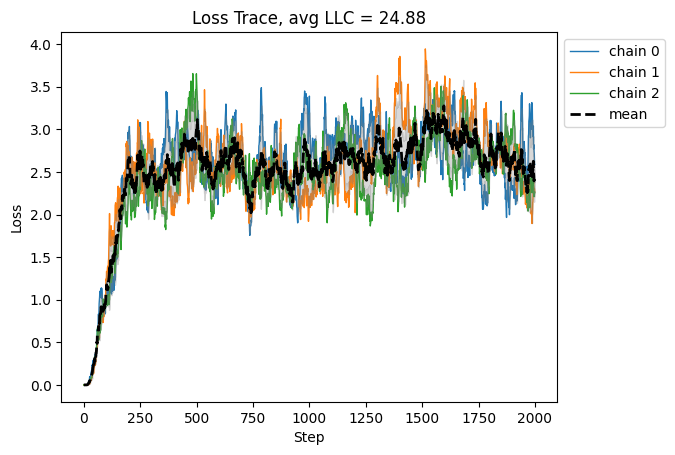

<Figure size 1200x900 with 0 Axes>

Chain 2: 100%|██████████| 2000/2000 [00:21<00:00, 91.52it/s]


saved_models/2026-01-27/attn1.0_seed1


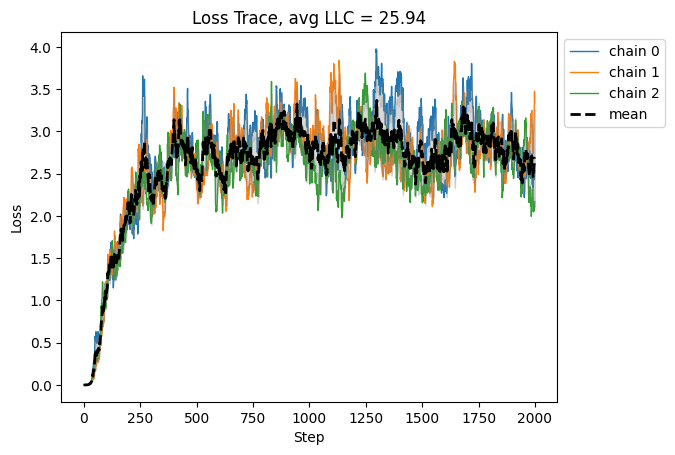

<Figure size 1200x900 with 0 Axes>

Chain 2: 100%|██████████| 2000/2000 [00:21<00:00, 91.93it/s]


saved_models/2026-01-27/attn1.0_seed2


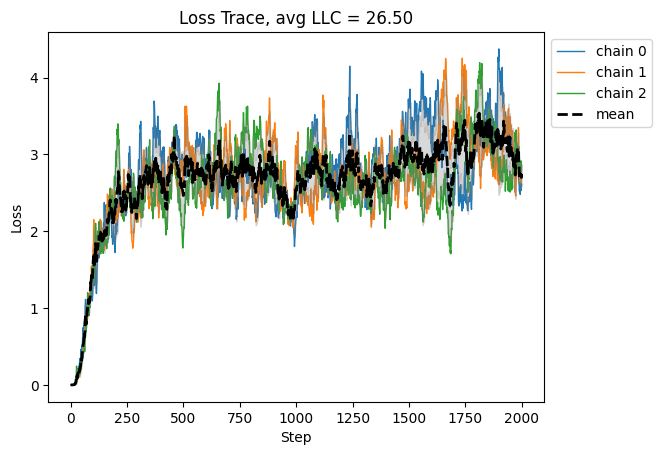

<Figure size 1200x900 with 0 Axes>

Chain 2: 100%|██████████| 2000/2000 [00:22<00:00, 90.75it/s]

saved_models/2026-01-27/attn1.0_seed3


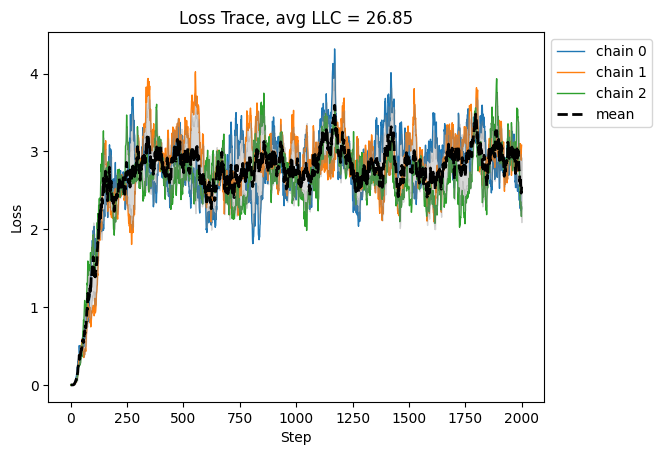

<Figure size 1200x900 with 0 Axes>

Chain 2: 100%|██████████| 2000/2000 [00:21<00:00, 93.19it/s]

saved_models/2026-01-27/attn1.0_seed4


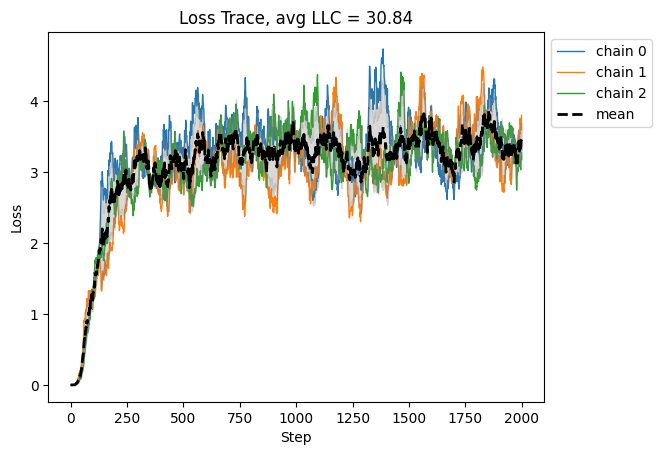

<Figure size 1200x900 with 0 Axes>

In [ ]:
attn_to_llc = {}
for attn in [0.0, 1.0]:
    attn_to_llc[attn] = []
    for seed in range(5):
        llc = estimate_and_plot_llc_for_final_model(
            dir_path=f"saved_models/2026-01-27/attn{attn}_seed{seed}",
            localization=100,
            lr=1e-4,
            num_draws=2000,
        )
        attn_to_llc[attn].append(llc)


In [4]:
attn_to_llc

{0.0: [np.float32(45.284325),
  np.float32(48.215866),
  np.float32(68.383354),
  np.float32(50.495735),
  np.float32(47.120453)],
 1.0: [np.float32(24.879566),
  np.float32(25.93705),
  np.float32(26.495615),
  np.float32(26.84756),
  np.float32(30.841604)]}

Some bad parameter settings

In [ ]:
sweep("saved_models/2026-01-27/attn0.0_seed4")

/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be 

saved_models/2026-01-27/attn0.0_seed4


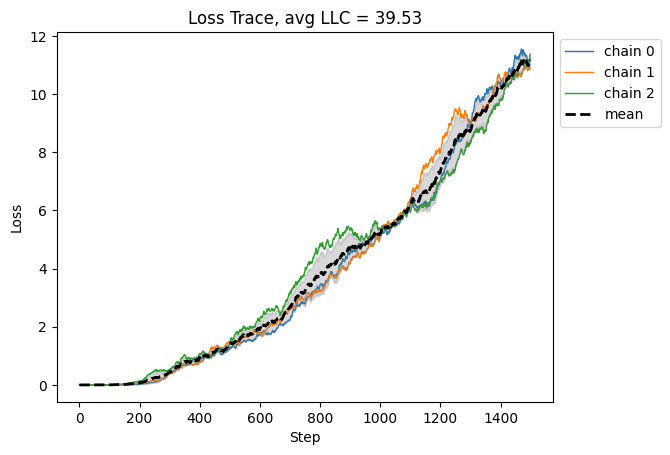

<Figure size 1200x900 with 0 Axes>

In [ ]:
estimate_and_plot_llc_for_final_model("saved_models/2026-01-27/attn0.0_seed4")

Chain 2: 100%|██████████| 1500/1500 [00:16<00:00, 91.35it/s]


saved_models/2026-01-27/attn1.0_seed3


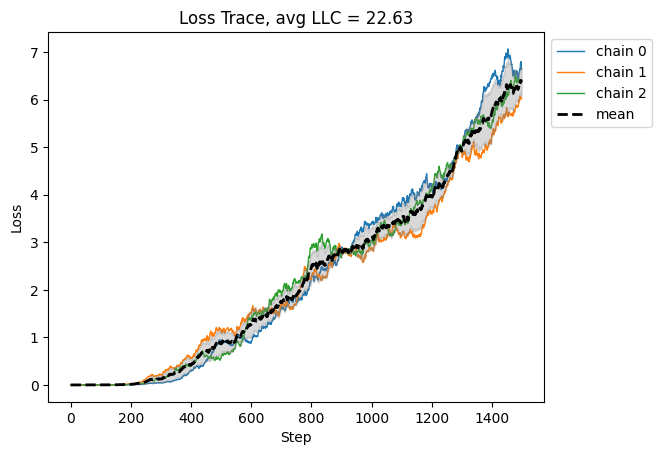

<Figure size 1200x900 with 0 Axes>

In [ ]:
estimate_and_plot_llc_for_final_model(dir_path="saved_models/2026-01-27/attn1.0_seed3")

/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be 

saved_models/2026-01-27/attn1.0_seed0


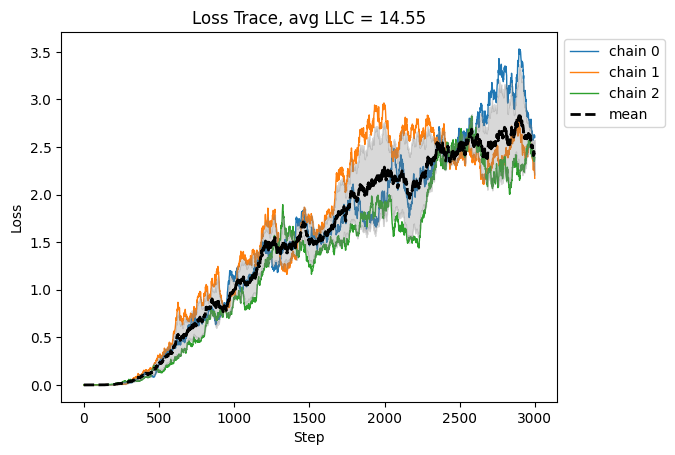

<Figure size 1200x900 with 0 Axes>

In [ ]:
estimate_and_plot_llc_for_final_model(
    dir_path="saved_models/2026-01-27/attn1.0_seed0",
    localization=100,
    lr=1e-5,
    num_draws=3000,
)

/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be 

saved_models/2026-01-27/attn1.0_seed0


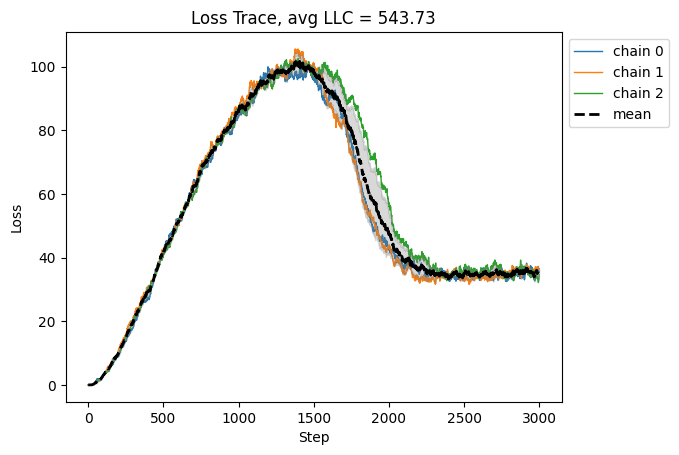

<Figure size 1200x900 with 0 Axes>

In [ ]:
estimate_and_plot_llc_for_final_model(
    dir_path="saved_models/2026-01-27/attn1.0_seed0",
    localization=10,
    lr=1e-4,
    num_draws=3000,
)